In [30]:
import torch
import numpy as np
import imutils
import time
import random
import cv2

from PIL import Image, ImageOps, ImageFont, ImageDraw
from torchvision import transforms

import matplotlib.pyplot as plt
import torch.nn as nn

import models.MathNet as mnt
import models.MathNet112 as mnt112
from utils.letter import Letter
from utils.printer import PrettyPrinter

In [87]:
MODEL_PATH = 'models\mathnet224\mathnet.ml'
printer = PrettyPrinter()

In [32]:
#CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
IMAGE_NAME = 'T:\my_programs\Math_recognition\TEST\\real1.jpg'
image = cv2.imread(IMAGE_NAME)

img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#set a thresh
thresh = 120

#get threshold image
ret,thresh_img = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imshow("tt", thresh_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))



In [34]:
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
1

1

In [35]:
def resize_letter(image, dst):
    return None

In [36]:
def add_border(image):
        pad = 10
        mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
        mask2 = np.pad(mask1, pad_width=pad)
        print(image.shape, mask1.shape, mask2.shape)
        res = cv2.bitwise_and(mask2, image)
        res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
        return res

In [37]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [38]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

In [39]:
class ContoursDetector():
    def __init__(self, model, kwargs):
        self.model = model
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.model.eval()
        self.kwargs = kwargs

    
    def preprocess(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.blur(gray, (3, 3))
        thresh_img = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,20)
        thresh_img = add_border(thresh_img)
        kernel = np.ones((1, 1), np.uint8)
        opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        img_erode = cv2.erode(closing, np.ones((3, 3), np.uint8), iterations=4)
        
        if self.kwargs['VISUALIZE'] == True:
            cv2.imshow('preprocess', img_erode)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        return img_erode

    def get_rois(self, image, orig):
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        blurred = cv2.blur(orig, (3, 3))
        image = add_border(image)
        contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
        img_contours = np.uint8(np.ones((image.shape[0],image.shape[1])))
        # Filter contours
        mask = np.uint8(np.ones((image.shape[0],image.shape[1])) * 255.)
        contours = contours[1:]
        for idx, contour in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            crop_orig = blurred[y:y+h, x:x+w]
            thresh_img = cv2.adaptiveThreshold(crop_orig, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,31,8)
            black_count = w*h - cv2.countNonZero(thresh_img)
            if black_count > 10:
                mask[y:y+h, x:x+w] = thresh_img
            else:
                pass
        if self.kwargs['VISUALIZE'] == True:
            cv2.imshow('preprocess', mask)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        mask = cv2.bitwise_not(mask)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))
        cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
        
        letters = []
        for idx, contour in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            if hierarchy[0][idx][3] != -1 or cv2.contourArea(contour) < 15:
                continue
            #_, blurred = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            crop_img = orig[y:y+h, x:x+w]
            letter = Letter(x,y,w,h,crop_img)
            letters.append(letter)
        return letters

    def visualize_rois(self, img, rois):
        output = Image.fromarray(img.astype('uint8'))        
        res_letters = []
        for idx in range(0, len(rois)):
            roi = rois[idx]
            res_letters.append(roi)
            draw = ImageDraw.Draw(output)
            draw.rectangle((roi.x, roi.y, roi.right, roi.bottom), outline=(255,0,0))
        output.show()
        return (output, res_letters)
        
    def visualize_preds(self, img, letters):
        #output = Image.new("RGBA", img.size)
        output = Image.fromarray(img.astype('uint8'))
        output = output.convert('RGB')
        font = ImageFont.truetype("T:\my_programs\Math_recognition\ARIALUNI.TTF", 10, encoding="unic")
        draw = ImageDraw.Draw(output)
        res_letters = []
        for letter in letters:
            res_letters.append(letter)
            draw.rectangle((letter.x, letter.y, letter.x+letter.width, letter.y+letter.height), outline=(0,255,0))
            draw.text((letter.x, letter.y), "{}; {:.3f}.".format(mnt.map_pred(letter.value), letter.score), font=font, fill=(200,40,0,255))
        display(output)
        return (output, res_letters)

    def get_exact_locations(self, rois):
        res = []
        (avg_w, avg_h) = average_size(rois)
        for letter in rois:
            if letter.w < avg_w / 2 and letter.height - avg_h / 2 < 0:
                continue
            _, thresh_img = cv2.threshold(letter.image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            letter.image = thresh_img
            res.append(letter)
        return res
    
    def predict(self, letters):
        regions_of_interest = []
        labels = {}
        torch.cuda.empty_cache()
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        for letter in letters:
            letter.add_frame()            
            img = Image.fromarray(letter.image.astype('uint8'))
            convert_tensor = transforms.Compose([
                transforms.Resize(self.kwargs['INPUT_SIZE']),
                transforms.Grayscale(1),
                transforms.GaussianBlur(3),
                # transforms.ToTensor()
            ])
            x_image = convert_tensor(img)
            x_image = add_contrast(x_image, 5)
            display(x_image)
            to_tensor = transforms.ToTensor()

            x_image = to_tensor(x_image)
            
            x_image = x_image.unsqueeze(0).float()
            x_image = x_image.to(device)

            predicted = self.model(x_image)
            prob = predicted.max().item()
            
            if prob >= self.kwargs['MIN_CONF']:
                letter.value = predicted.argmax().item()
                letter.score = prob
                ll = labels.get(letter.value, [])
                ll.append(letter)
                labels[letter.value] = ll
                regions_of_interest.append(letter)
                print(letter.value, prob, printer.char(letter.value))
        return (regions_of_interest, labels)
    

    def __call__(self, img):
        processed_image = self.preprocess(img)
        regions_of_interest = self.get_rois(processed_image, img)

        if self.kwargs['DEBUG'] == True:
            print('regions_of_interest = ', len(regions_of_interest))
            self.visualize_rois(img, regions_of_interest)

        regions_of_interest = self.get_exact_locations(regions_of_interest)
        #self.add_spaces_to_letter(regions_of_interest)

        (regions_of_interest, preds) = self.predict(regions_of_interest)
        if self.kwargs['DEBUG'] == True:
            print('letters predicted = ', len(regions_of_interest))

        if self.kwargs['DEBUG'] == True:
            print('found letters = ', len(regions_of_interest))
        (_, letters) = self.visualize_preds(img, regions_of_interest)
        # printer = PrettyPrinter()
        # printer.print(letters)
        return (_, letters)

(994, 1080) (974, 1060) (994, 1080)
(994, 1080) (974, 1060) (994, 1080)
regions_of_interest =  20


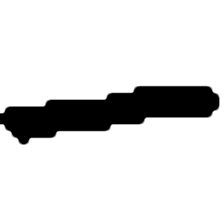

3 8.51217269897461 -


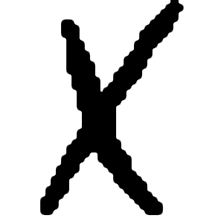

40 5.501543045043945 x


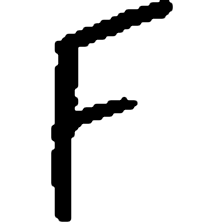

17 5.527338981628418 F


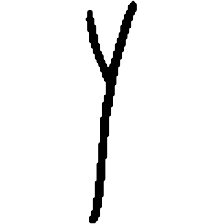

41 7.0961713790893555 y


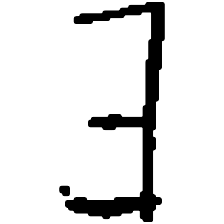

24 10.669022560119629 ∃


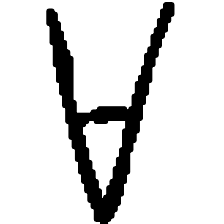

25 6.7579827308654785 ∀


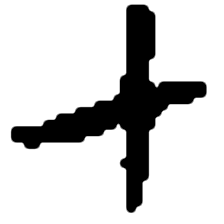

2 2.6573586463928223 +


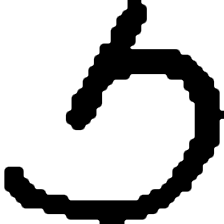

32 0.4671503007411957 φ


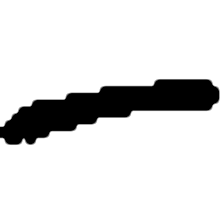

3 8.07450008392334 -


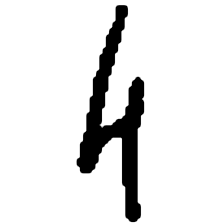

15 2.6197497844696045 A


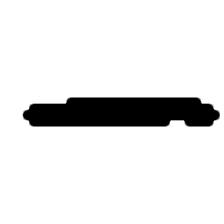

3 7.601037502288818 -


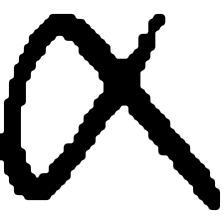

19 6.575932025909424 α


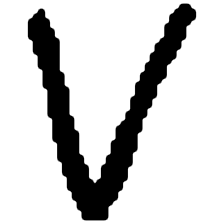

39 7.540387153625488 υ


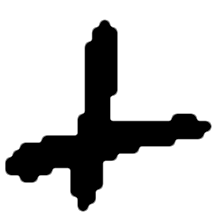

27 2.1200568675994873 λ


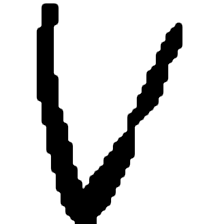

39 8.912215232849121 υ


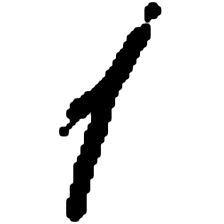

5 2.554565668106079 1


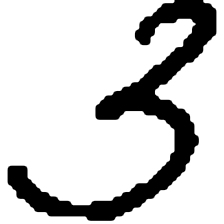

17 2.308035373687744 F


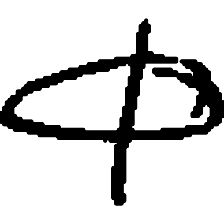

32 6.689545154571533 φ


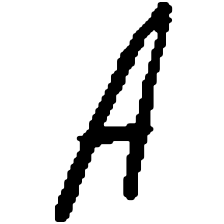

15 8.376703262329102 A
letters predicted =  19
found letters =  19


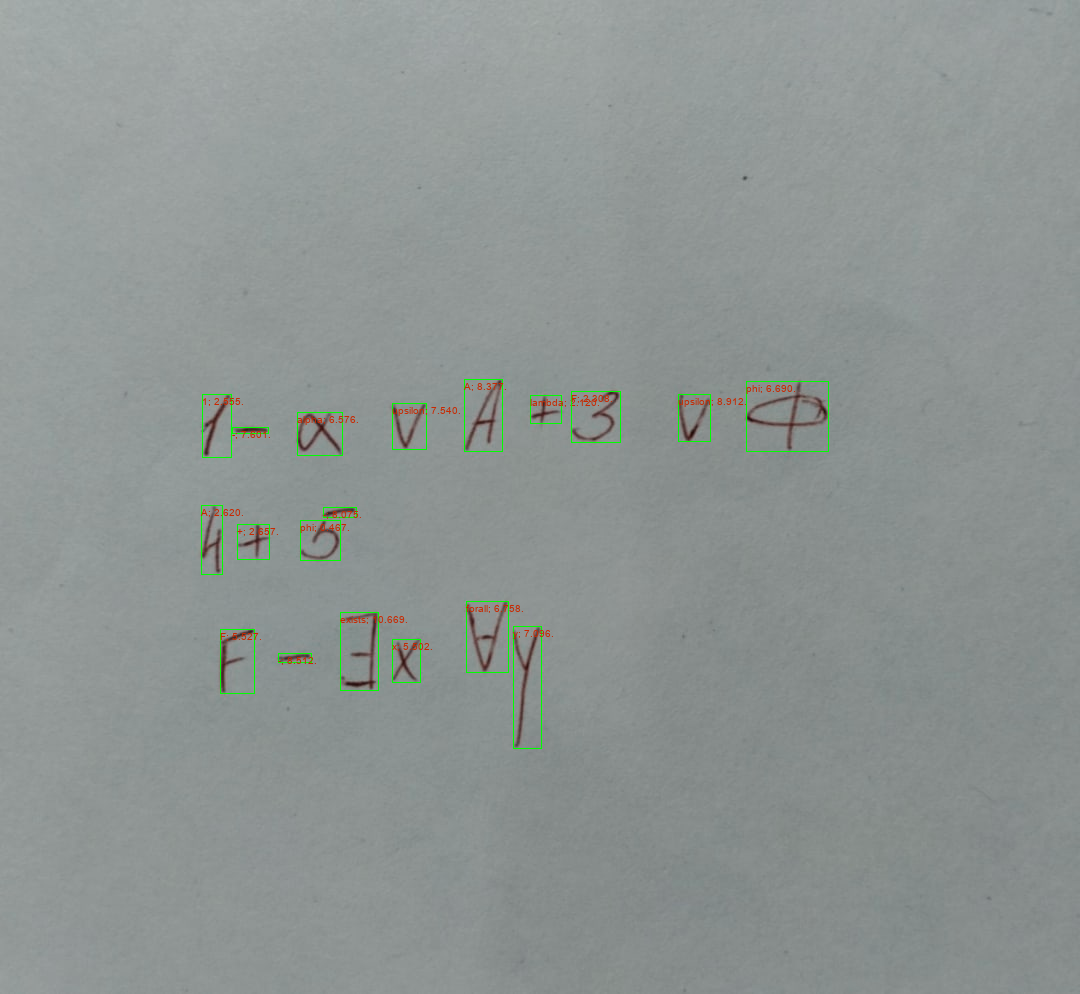

In [40]:
path = 'T:\my_programs\Math_recognition\TEST\\real3.jpg'
kwargs = dict(
        INPUT_SIZE=(224, 224),
        VISUALIZE=True,
        MIN_CONF=0.05,
        DEBUG=True
    )
image = cv2.imread(path)
model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
sw = ContoursDetector(model, kwargs)
res = sw(image)


19


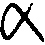

In [41]:
first = res[1][11]
let_image = Image.fromarray(first.image.astype('uint8'))
print(first.value)
display(let_image)

In [42]:
def letters_extract(image_file, debug=False):
    img = cv2.imread(image_file)
    output = img.copy()
    if debug==True:
        cv2.imshow('MyPhoto', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh = 100
    thresh_img = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,8)
    ret,thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    if debug==True:
        cv2.imshow('thresh_img', thresh_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)
    if debug==True:
        cv2.imshow('MyPhoto', img_erode)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    # cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    # cv2.imshow('img_contours', img_contours )
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
       
    # Filter contours
    mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 10 and cv2.contourArea(contour) < 10000:
            cv2.drawContours(mask, [contour], 0, (255), -1)
        else:
            pass
#             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
#             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
#             print(w*h, cv2.contourArea(contour))
#             cv2.imshow(str(idx), dummy )
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
            
#     # apply the mask to the original image
    result = cv2.bitwise_and(img,img, mask= mask)   
    if debug==True:
        cv2.imshow('result', result )
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    if debug==True:
        cv2.imshow('Contours', img_contours )
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        if hierarchy[0][idx][3] != -1:
            continue
#         mask_contour = img_contours[y:y+h, x:x+w]
#         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
#         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
#         cv2.imshow('MyPhoto', mask_contour)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
#         ii = cv2.imread('mask.png')
#         cv2.imshow('MyPhoto', ii )
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        crop_img = img_erode[y:y+h, x:x+w]
        #crop_img = thresh_img[y:y+h, x:x+w]
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = crop_img
        elif w < h:
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = crop_img
        else:
            letter_square = crop_img
        #letter_square = cv2.dilate(letter_square, np.ones((3, 3), np.uint8), iterations=1)
        x,y,w,h = cv2.boundingRect(contour)
        #rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
        inverted = cv2.bitwise_not(letter_square)
        
        letter = Letter(x,y,w,h,letter_square)
        letters.append(letter)

    letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
    aaa = Image.fromarray(output.astype('uint8'))
    #display(aaa)
    return (letters, aaa)

In [43]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [44]:



def img_to_str(model, image_file, debug=False):
    (letters, output) = letters_extract(image_file)   
    font = ImageFont.truetype("T:\my_programs\Math_recognition\ARIALUNI.TTF", 10, encoding="unic")
    draw = ImageDraw.Draw(output)
    
    print('SHAPE: ', np.array(letters,dtype=object).shape)
    if len(letters) == 0:
        return "Found nothing"
    (avg_w, avg_h) = average_size(letters)
    print((avg_w, avg_h))
    
    # True sorting by Y axis
    line = 0
    for i in range (1, len(letters)):
        if letters[i].top > letters[i-1].bottom:
            line += 1
        letters[i].line = line
    letters.sort(key=lambda ll: (ll.line, ll.x), reverse=False)  
    
    prev_loc = (letters[0].x, letters[0].y)
    prev_size = (letters[0].width, letters[0].height)
    prev_line = letters[0].line
    #for i in range(1):
    for letter in letters:
        
        img = Image.fromarray(letter.image.astype('uint8'))
        convert_tensor = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Grayscale(1),
            # transforms.ToTensor()

        ])         
        x_image = convert_tensor(img)
        x_image = add_contrast(x_image, 5)
        to_tensor = transforms.ToTensor()

        x_image = to_tensor(x_image)
        aaa = transforms.ToPILImage()
        #display(aaa(x_image))
        x_image = x_image.unsqueeze(0).float()
        x_image = x_image.to(device)
        pred = model(x_image) 
        letter.score = pred.max().item()
        #print(letter.score)
        if letter.score > 0.65:
            letter.value = pred.argmax().item()
            x = letter.x
            y = letter.y
            size = (letter.width, letter.height)
            if (letter.line >  prev_line):
                prev_line = letter.line
            prev_loc, prev_size = (x,y), size
            #print(letter.image.shape, letter.value, prob)
            draw.rectangle((letter.x, letter.y, letter.x+letter.width, letter.y+letter.height), outline=(0,255,0))
            draw.text((letter.x, letter.y), "{}; {:.3f}.".format(mnt.map_pred(letter.value), letter.score), font=font, fill=(200,40,0,255))
    display(output)
    #output.show()

In [45]:
model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

EVALUATION


SHAPE:  (29,)
(37.48275862068966, 47.793103448275865)


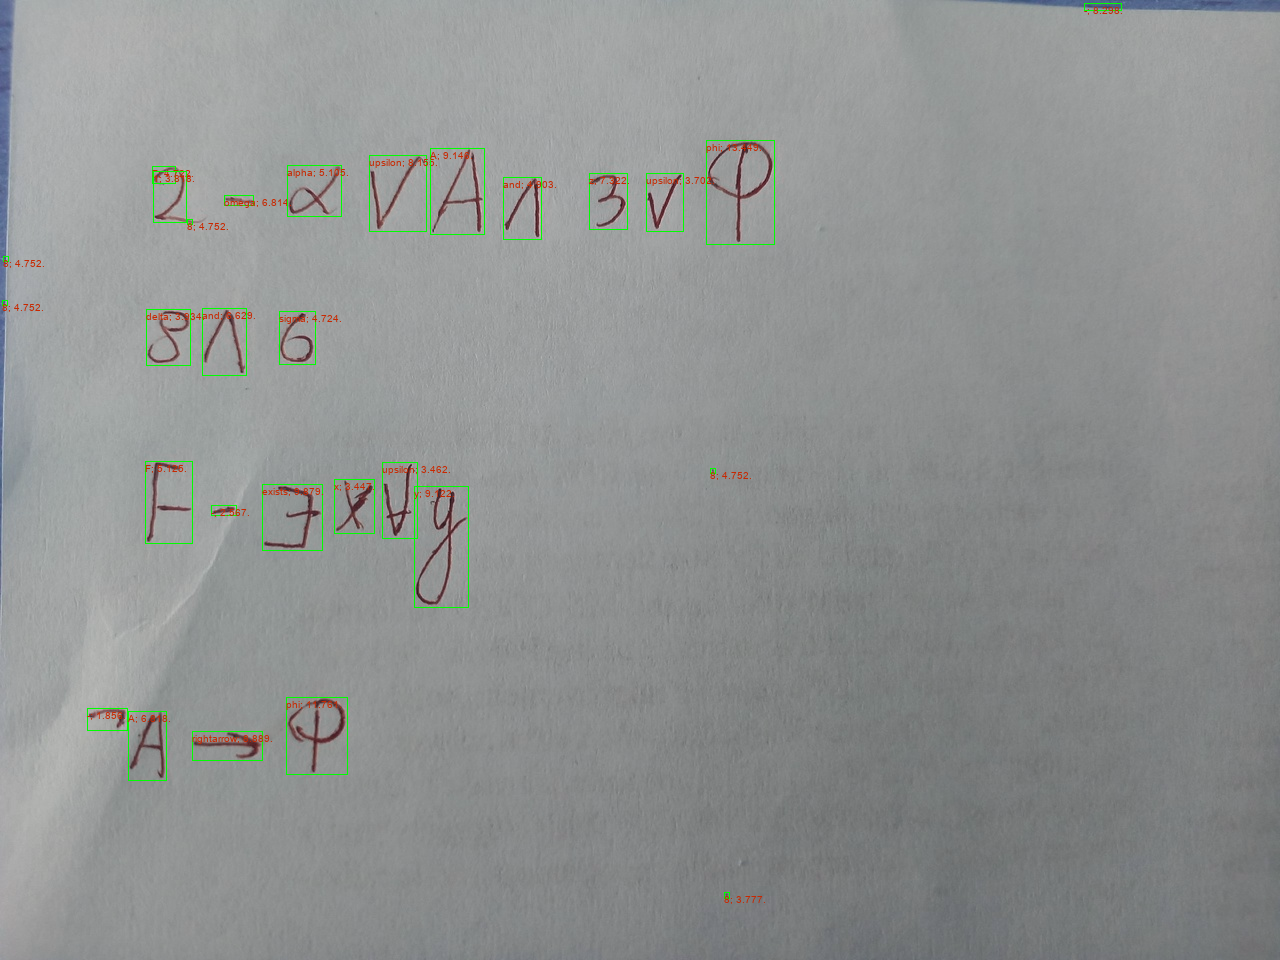

RESULT:
None


In [46]:
s = img_to_str(model, 'TEST/real5.jpg', 1)
print('RESULT:')
print(s)

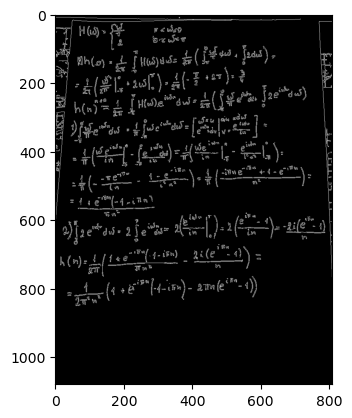

-1

In [47]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('TEST/h.jpg')
edges = cv2.Canny(img,25,255,L2gradient=False)
plt.imshow(edges, cmap='gray')
plt.show()
cv2.waitKey(0)

In [48]:
# import os
# from os import makedirs
# from os.path import isfile, join, exists

# def custom_sort(countour):
#     return -cv2.contourArea(countour)

# def remove_isolated_pixels(image):
#     connectivity = 8

#     output = cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S)

#     num_stats = output[0]
#     labels = output[1]
#     stats = output[2]

#     new_image = image.copy()

#     for label in range(num_stats):
#         if stats[label,cv2.CC_STAT_AREA] == 1:
#             new_image[labels == label] = 0

#     return new_image

# symbol = 'g'
# path = r'E:\Download\Query\\' + symbol + '\\'
# onlyfiles = [f for f in os.listdir(path) if os.path.isfile(join(path, f))]
# if not os.path.exists(path + 'new\\'):
#     makedirs(path + 'new\\')
# for i, file in enumerate(onlyfiles):
#     img = cv2.imread(path + '\\' + file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # Get contours
    
#     for x in range(0, img.shape[1]):
#         gray[img.shape[0]-6][x] = 255
#     for x in range(0, 3):    
#         for y in range(0, img.shape[0]):
#             gray[y][x] = 255
#             gray[y][ img.shape[1] - 1 - x] = 255

#     gray = cv2.bitwise_not(gray)
#     gray =  cv2.bitwise_not(remove_isolated_pixels(gray))
#     #gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=1)
#     cv2.imwrite(path + 'new\\' + symbol + '-' + str(i) + '.jpg', gray)

#     # cv2.imshow('result', img )
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

In [95]:
import os
from os import makedirs
from os.path import isfile, join

symbol = '0'
path = r'G:\TRAIN\images_contrast_to224\\' + symbol + '\\'
#path = r'G:\TRAIN\hasy_sorted\\' + symbol + '\\'
#path = r'G:\TRAIN\by_class\\' + symbol + '\\'
#path = r'E:\Download\Query\\' + symbol + '\\'
#path = r'E:\TRAIN\emnist\\' + symbol + '\\'

def __add_border(image, pad=2):
    mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
    mask2 = np.pad(mask1, pad_width=pad)
    res = cv2.bitwise_and(mask2, image)
    res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
    return res

In [50]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

def save_contrast(image, i):
    
    image = cv2.blur(image, (3,3))
    image = Image.fromarray(image)
    image = add_contrast(image, 4)
    image.save(path + 'sized\\' + symbol + '-' + str(i) + '-contrast.jpg')

In [51]:
def save_crop(gray, i, center_crop=False, prob=0):
    # gray = cv2.resize(gray, (20, 20))
    # gray = np.pad(gray, pad_width=4, constant_values=[255])
    if (center_crop==True):
        gray = gray[40:90, 40:90]
        sized = cv2.resize(gray, (224, 224))
        cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-crop.jpg', sized)  

    erode = __add_border(gray)
    contours, hierarchy = cv2.findContours(erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 1:
        #print(len(contours))
        #(x,y,w,h) = cv2.boundingRect(contours[-1])
        (x, y) = (erode.shape[1], erode.shape[0])
        w = h = 0
        #print(x,y,w,h)
        for idx in range (1, len(contours)):
            print(hierarchy[0][idx][3])
            if hierarchy[0][idx][3] != -1:
                continue
            (x1,y1,w1,h1) = cv2.boundingRect(contours[idx])
            x = min(x, x1)
            y = min(y, y1)
            w = max(w, x1+w1)
            h = max(h, y1+h1)
            #print(x,y,w,h)
        if w - x < 12 or h - y < 12:
            (x,y,w,h) = (0, 0, erode.shape[1], erode.shape[0])
        print(x,y,w,h)
        erode = erode[y:h, x:w]
        # cv2.imshow("e", erode)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        #if (random.randint(0, 100) < prob):
        #sized = cv2.resize(erode, (224 + pad, 224 + pad))
        sized = np.pad(erode, pad_width=random.randint(0, 64), constant_values=[255])
        sized = cv2.resize(sized, (224, 224))
        #sized = cv2.dilate(sized, np.ones((3, 3), np.uint8), iterations=16)
        #sized = np.pad(sized, pad_width=12, constant_values=[255])
        # cv2.imshow("cropped", sized)
        # cv2.waitKey(0)
        cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-crop.jpg', sized)  

In [96]:
def save_erode(gray, i):
    erode = cv2.erode(gray, np.ones((6, 6), np.uint8), iterations=4)
    cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-erode.jpg', erode)  

In [97]:

# onlyfiles = [f for f in os.listdir(path) if isfile(join(path, f))]
# if not os.path.exists(path + 'sized\\'):
#     makedirs(path + 'sized\\')

# for i, file in enumerate(onlyfiles):
#     if (i > 3100):
#         break
#     img = cv2.imread(path + '\\' + file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     sized = cv2.resize(gray, (224, 224), interpolation = cv2.INTER_AREA)
#     #cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '.jpg', sized)
#     # gray = cv2.flip(sized, 0)
#     # gray = cv2.rotate(sized, cv2.ROTATE_90_CLOCKWISE)
#     # cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-mirrorb.jpg', gray)
#     #save_erode(sized, i)
#     #save_crop(gray, i, False, prob=35)
#     save_contrast(gray, i)

#     # cv2.imshow('result', img )
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

50176
48676
0.9701052295918368
Center of mass coordinates: (96.98, 84.05533333333334)
10 (204, 204) (224, 224)
ok


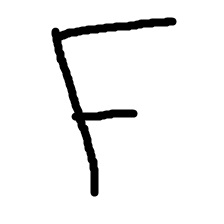

In [54]:
img = Image.open("TEST/0.jpg")
roiOrig = cv2.imread("TEST/0.jpg")
roiOrig = cv2.cvtColor(roiOrig,cv2.COLOR_BGR2GRAY)

def add_border(image):
    pad = 10
    mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
    mask2 = np.pad(mask1, pad_width=pad)
    print(pad, mask1.shape, mask2.shape)
    mask1 = np.uint8(np.ones((int(image.shape[0]), int(image.shape[1])))* 255.0)
    res = cv2.bitwise_and(mask2, image)
    res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
    return res

# skip blank images   
area = img.size[0]*img.size[1]    
print(area)
print(cv2.countNonZero(roiOrig))
print(cv2.countNonZero(roiOrig) / area)
indices = np.argwhere(roiOrig == 0)

# Calculate the center of mass coordinates
center = np.mean(indices, axis=0)

print("Center of mass coordinates: ({}, {})".format(center[1], center[0]))

roiOrig = add_border(roiOrig)
# cv2.imshow("aa", roiOrig)
# cv2.waitKey(0)
if (cv2.countNonZero(roiOrig) / area < 0.99):         
#if (img.size[0]*img.size[1] - cv2.countNonZero(roiOrig) != 0):
    roi = cv2.resize(roiOrig, (224, 224))
    roi = cv2.dilate(roi, np.ones((3, 3), np.uint8), iterations=1)
    print('ok')
display(img)
img.close()

EVALUATION


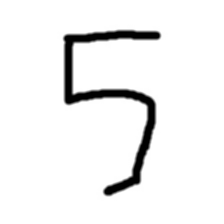

tensor(2.8498, device='cuda:0', grad_fn=<MaxBackward1>) 9
5
tensor([[-9.9957e+01, -6.6804e+01, -1.2662e+02, -9.4217e+01, -9.6270e+01,
         -1.0779e+02, -1.4646e+02, -3.6533e+01, -1.2185e+02,  2.8498e+01,
         -9.7660e+01, -1.0610e+02, -8.6475e+01, -4.6310e+01, -1.0147e+02,
         -1.2138e+02, -8.4287e+01, -8.0693e+00, -7.6344e+01, -7.8568e+01,
         -5.0662e+01, -5.3695e+01, -3.7576e+01, -5.8134e+01, -3.9685e+01,
         -8.1916e+01, -8.7727e+01, -9.4046e+01, -8.3376e+01, -1.1263e+01,
         -1.3236e+02, -1.0693e+02, -7.0541e+01, -4.2989e+01, -7.9111e+01,
         -7.9210e+01,  6.2104e+00, -5.1316e-01, -8.6845e+01, -8.1247e+01,
         -1.3901e+02, -9.3965e+01, -8.8603e+01, -8.4673e-02]], device='cuda:0',
       grad_fn=<MulBackward0>)



In [108]:
import cv2
from PIL import Image, ImageOps



model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

output =  cv2.imread("TEST/0.jpg")
gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
gray = cv2.blur(gray, (3, 3))
#_, gray = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh = 90
#gray = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,5)
#ret,thresh_img = cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#gray = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)

#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(1),
    # transforms.ToTensor()

])        
x_image = convert_tensor(Image.fromarray(gray))
#x_image = add_contrast(x_image, 5)
to_tensor = transforms.ToTensor()

x_image = to_tensor(x_image)
aaa = transforms.ToPILImage()
display(aaa(x_image))
#aaa(x_image).save('a.jpg')

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image)
print(pred.max(), pred.argmax().item())
print(printer.char(pred.argmax().item()))
print(pred*10)
printer = PrettyPrinter()
#print(pred[0][15])
print()
